In [88]:
import csv
import copy
import numpy as np
import random
from igraph import *
import math
import itertools
from itertools import groupby
from itertools import chain
from operator import itemgetter
from scipy.optimize import linear_sum_assignment
import time
import multiprocess
from networkx import Graph
from networkx import connected_components
from networkx.algorithms import bipartite
from networkx.algorithms.bipartite.matching import minimum_weight_full_matching, maximum_matching, hopcroft_karp_matching
from networkx.algorithms import maximal_matching
import random
import seaborn as sns
import pandas as pd

In [89]:
# 50 000 users - 10 favourites

big_likes = []
big_users = []
big_items = []

with open('bipartite_10.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        big_likes.append([row[0], row[1], 1])
        big_users.append(row[0])
        big_items.append(row[1])


big_users = np.unique(big_users).tolist()

big_items = np.unique(big_items).tolist()

big_user_items = {user: list(list(zip(*item))[1]) for user, item in groupby(big_likes, itemgetter(0))}

In [90]:
# k among n combinations
def combinations(args):
    user, items, k = args
    return np.array([[user, '&'.join(row)] for row in list(itertools.combinations(items, k))])


In [93]:

def full_match(users, items, user_items, likes):
    """
        Parameters
        ----------
            data: List[Tuple[int, int]]
                List of couples like (user_id, item_id).
                An item could be a song, an artist or something else.

        Returns
        ----------
            fingerprints: List[Tuple[int, List[int]]]
                List of couples like (user_id, fingerprint).
                Fingerprint being a list of items.
            cost: int
                Sum of the lengths of all of the fingerprints.
            k: int
                Length of the biggest fingerprint.
    """
    
    # Pour k allant de 1 à n?
    for k in range (1, 10):
        
        # Création des ensembles des items de taille allant de 1 à k
        if k == 1:
            G = Graph()
            # Add nodes with the node attribute "bipartite"
            G.add_nodes_from(users, bipartite=0)
            G.add_nodes_from(items, bipartite=1)
            # Add edges only between nodes of opposite node sets
            G.add_weighted_edges_from(likes)
            
        else:
            # Si on a un fingerprint pour chaque user - fin de la fonction
            if len(fingerprints) == len(users):
                return fingerprints
            
            # Sinon - générer les combinaisons qui existent parmi les ensebles d'items des users
            else:
                #print(len(np.unique(fingerprints.keys())), len(np.unique(users)))
                #undefined_users = [u for u in users if u not in fingerprints.keys()]
                #print(undefined_users)
                try:
                    # Create items combinations of size k
                    pool = multiprocess.Pool()
                    my_combinations = pool.map(combinations, 
                                               ([user, item_list, k] for user, item_list in user_items.items() 
                                                if len(item_list) >= k))
                    new_likes = []

                    
                    for i in range(0, len(my_combinations)):
                        for j in range(0, len(my_combinations[i])):
                            new_likes.append([my_combinations[i][j][0], my_combinations[i][j][1], k])
                            
                    new_items = np.array(np.unique(np.array(new_likes)[:,1]))
                    
                    G.add_nodes_from(new_items, bipartite=1) 
                    G.add_weighted_edges_from(new_likes)
                    
                # To make sure processes are closed in the end, even if errors happen
                finally: 
                    pool.close()
                    pool.join()

                    
        # Init fingerprints             
        fingerprints = {}
        # Go through connected components of the graph
        for c in connected_components(G):
            matchings = maximal_matching(G.subgraph(c))
            for m in matchings: 
                if m[0].lower().islower():
                    fingerprints[m[0]] = m[1]
                else:
                    fingerprints[m[1]] = m[0]
                    
        # Calculate sum_cards and avg_card 
        sum_cards = 0
        
        for f in fingerprints.values():
            sum_cards += f.count('&') + 1
        
        avg_card = sum_cards / len(fingerprints.values())
        #print('avg_card', avg_card)
        
        #print('Nb fingerprints', len(fingerprints), 'Sum of fingerprints cardinals:', sum_cards, 'avg_card:', avg_card, 'k:', k)
        
        # If there is a fingerprint for each user - end of algorithm
        if len(fingerprints) == len(users):
            return fingerprints, sum_cards, avg_card, k
        
    return fingerprints, sum_cards, avg_card, k

In [96]:
# From 100 to 10 000 users

results = []

for power in range(2,5):
    
    avg_cards = []
    sum_cards = []
    ks = []
    
    for i in range(0,10):
        users = random.sample(big_users, k=10**power)
        user_items = {}

        for u in users:
            user_items[u] = big_user_items[u]

        items = np.unique(list(chain.from_iterable(list(user_items.values())))).tolist()

        likes = []
        for user, item_list in user_items.items():
            for item in item_list:
                likes.append([user, item, 1])

        # Fingerprints

        fingerprints, sum_card, avg_card, k = full_match(users, items, user_items, likes)
        
        avg_cards.append(avg_card)
        sum_cards.append(sum_card)
        ks.append(k)
    
    results.append({'nb_users': 10**power,
                    'avg_avg_cards': sum(avg_cards) / 10,
                    'avg_k': sum(ks) / 10,
                    'max_k': max(ks)})
    
    print({'nb_users': 10**power,
           'avg_avg_cards': sum(avg_cards) / 10,
           'avg_k': sum(ks) / 10,
           'max_k': max(ks)})

{'nb_users': 100, 'avg_avg_cards': 1.0, 'avg_k': 1.0, 'max_k': 1}
{'nb_users': 1000, 'avg_avg_cards': 1.0733000000000001, 'avg_k': 2.0, 'max_k': 2}
{'nb_users': 10000, 'avg_avg_cards': 1.4044299999999996, 'avg_k': 3.0, 'max_k': 3}


In [97]:
# For 50 000 users

fingerprints, sum_card, avg_card, k = full_match(big_users, big_items, big_user_items, big_likes)

results.append({'nb_users': 50000,
                'avg_avg_cards': avg_card,
                'avg_k': k,
                'max_k': k})


In [102]:
df = pd.DataFrame.from_dict(results)
print(df)

   nb_users  avg_avg_cards  avg_k  max_k
0       100        1.00000    1.0      1
1      1000        1.07330    2.0      2
2     10000        1.40443    3.0      3
3     50000        1.66698    3.0      3


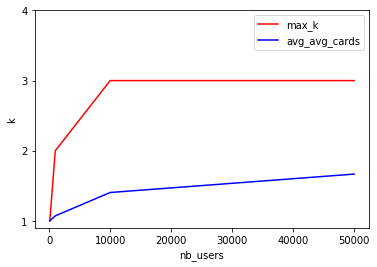

<Figure size 432x288 with 0 Axes>

In [87]:
ax = plt.gca()
plt.figure()
df.plot(kind='line',x='nb_users',y='max_k',color='red', ax=ax, yticks=[1, 2, 3, 4], ylabel='k')
df.plot(kind='line',x='nb_users',y='avg_avg_cards',color='blue', ax=ax, yticks=[1, 2, 3, 4])
plt.show()